# Approach: The goal of this exercise is to predict whether an email is spam or not. Given the dataset, the following is the approach to the problem - 
1. Exploratory Data Analysis - Data Cleaning, treatment and transformation
2. Determination of Evaluation Metric to be Used
3. Build Models using the following algorithms - 
   a. Logistic Regression 
   b. K-NN
   c. Regression Tree
   d. Neural Network 
   e. Random Forest
4. Finalize the model to be used based on the evaluation metric on the test data set   


The data set has been downloaded from UCI dataset  http://archive.ics.uci.edu/ml/datasets/Spambase


##### Algroithms considered - 
###### a. Decision Tree: Decision tree automatically handles outliers and selects the most relevant features in its algorithm. So no  need to manually do feature selection 
###### b. Logistic Regression: Look at the correlation matrix first. If high correlation then remove those variables and then use the rest for L1 which does the feature selection automatically
###### c. KNN - two variants - use the best logistic regression's output which gives the coeff and drop the variables and do one iteration without dropping anythin 
###### d. Neural Network - the same as above 
###### e. Random Forest - use max_features 

In [183]:
from  sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings; warnings.simplefilter('ignore')
## Plotting Learning Curves
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,scoring_metric = None, scoring_metric_label = "score",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring_metric_label)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring_metric)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_results( grid ,par_1,par_2, title, y_lab):
    """Select two hyperparameters from which we plot the fluctuations"""
    index = 'param_' + par_1
    columns = 'param_' + par_2

    # prepare the results into a pandas.DataFrame
    df = pd.DataFrame(grid.cv_results_)

    # Remove the other by selecting their best values (from gscv.best_params_)
    other = [c for c in df.columns if c[:6] == 'param_']
    other.remove(index)
    other.remove(columns)
    # Create pivot tables for easy plotting
    table_mean = df.pivot_table(index=index, columns=columns,
                                values=['mean_test_score'])
    table_std = df.pivot_table(index=index, columns=columns,
                               values=['std_test_score'])

    # plot the pivot tables
    plt.figure()
    ax = plt.gca()
    for col_mean, col_std in zip(table_mean.columns, table_std.columns):
        table_mean[col_mean].plot(ax=ax, yerr=table_std[col_std], marker='o',
                                  label=col_mean)
    plt.title(title)
    plt.ylabel(y_lab)
    plt.legend(title=table_mean.columns.names)
    plt.show()



In [184]:
import pandas as pd
import numpy as np 
path = 'Please insert path here'
check = pd.read_csv(path + 'spambase.names',skiprows =32, names = ['name','val1','val2'])
colnames = check.name.str.split(':',expand = True)[0]
colnames = colnames.append(pd.Series('spam'))
df= pd.read_csv(path + "spambase.data", header = None, names = colnames)

In [64]:
df.shape

(4601, 58)

In [67]:
df['spam'].value_counts()/df.shape[0]

0    0.605955
1    0.394045
Name: spam, dtype: float64

#### We can see that the basic model would give an accuracy of 60.5 %. Since the data is not hughely imbalanced, AUROC is used for evaluating the models

In [186]:
# From the documentation, we can see that there are no missing values in the dataset. 
# The data set appears to be clean and ready for analysis

In [69]:
df.corr()
#df.corr().to_csv(path + 'hw3_quesn2_correlation_matrix_20191104.csv')


##### We can see that there is a high correlation within the variables. 'word_freq_direct','word_freq_415','word_freq_telnet' are the variables selected to be removed from the data set as they have very high correlation with other variables and relatively less with 'Spam' variable

##### Since decision tree is agnostic to the correlated variables, they have not been removed yet from the data 

In [188]:
# train Test Split
df_y = df.iloc[:,57].values
df_x = df.iloc[:,0:57].values
x_train,x_test,y_train,y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 123,stratify = df_y)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [189]:
# Decision Tree
depth={"max_depth":[1,10,20,30,40,50],
       "min_samples_leaf" : [10,20,30]}       

DTC=DecisionTreeClassifier()

grid_dt=GridSearchCV(DTC,param_grid=depth , cv=4, scoring= make_scorer(roc_auc_score))
grid_dt.fit(x_train,y_train) 
dt_result =pd.DataFrame(grid_dt.cv_results_)
grid_dt.best_params_

{'max_depth': 30, 'min_samples_leaf': 10}

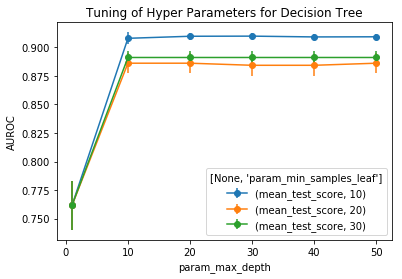

In [190]:
plot_results( grid_dt ,par_1 = "max_depth",par_2 = "min_samples_leaf", title = "Tuning of Hyper Parameters for Decision Tree", y_lab= "AUROC")

In [193]:
# Logistic Regression
# Using the correlation criteria above as discussed the variables are removed 
# before modeling as L1 penalty is sensitive to highly correlated variables
data_log = df.copy()
data_log.drop(columns = ['word_freq_direct','word_freq_415','word_freq_telnet'], inplace = True)
df_y = data_log.iloc[:,54].values
df_x = data_log.iloc[:,0:54].values
x_train,x_test,y_train,y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 123,stratify = df_y)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [194]:
c_vals={"C":[0.001,0.01,1,10]}       

log=LogisticRegression(penalty = 'l1')

grid_log=GridSearchCV(log,param_grid=c_vals , cv=4, scoring= make_scorer(roc_auc_score))
grid_log.fit(x_train,y_train) 
log_result =pd.DataFrame(grid_log.cv_results_)
grid_log.best_params_

{'C': 1}

In [196]:
log_final = LogisticRegression(**grid_log.best_params_)
log_final.fit(x_train, y_train)
y_pred_log = log_final.predict_proba(x_test)[:,1]
print('AUROC score for Logistic Regression L1 Penalty :',roc_auc_score(y_test,y_pred_log))

AUROC score for Logistic Regression L1 Penalty : 0.9711089388508743


In [104]:
log_final.coef_

array([[-0.08170917, -0.18772932,  0.09153032,  0.76394935,  0.29127194,
         0.24607626,  0.94473294,  0.25822021,  0.12580926,  0.0802277 ,
        -0.02520744, -0.13448805,  0.00621931,  0.03477124,  0.54985657,
         0.9567425 ,  0.39880931,  0.06636639,  0.16386468,  0.57858941,
         0.26093154,  0.31156442,  0.72823536,  0.2240301 , -2.69403767,
        -0.85794339, -4.36729794,  0.1434975 , -0.99565202, -0.13871528,
        -0.09380995, -0.45269133, -0.87191861,  0.42370211, -0.01558457,
        -0.152521  , -0.2479047 , -1.66663364, -1.27956344, -0.25763236,
        -1.08456693, -0.75293345, -1.20164487, -0.22077211, -0.71773113,
        -0.37058825, -0.08549438, -0.13174886,  0.29971836,  1.09106517,
         1.03884828, -0.15829411,  0.88688288,  0.44904656]])

#### Since all the coefficients pbtained in l1 penalty are non-zero, no more variables are removed from the data set for algorithms used later

In [197]:
#KNN
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, cv = 4, scoring = make_scorer(roc_auc_score))
grid_knn.fit(x_train,y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

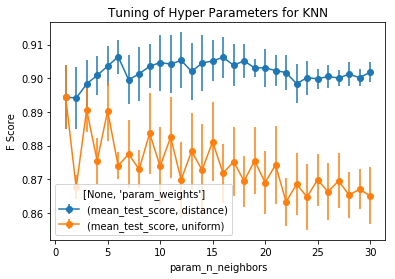

In [198]:
plot_results(grid_knn ,par_1 = "n_neighbors",par_2 = "weights", title = "Tuning of Hyper Parameters for KNN", y_lab= "F Score")


In [199]:
grid_knn.best_params_

{'n_neighbors': 6, 'weights': 'distance'}

In [200]:
final_knn = KNeighborsClassifier(**grid_knn.best_params_)
final_knn.fit(x_train, y_train)
y_pred_knn = final_knn.predict_proba(x_test)[:,1]
print('AUROC score for KNN :',roc_auc_score(y_test,y_pred_knn))

AUROC score for Logistic Regression L1 Penalty : 0.9659448838334468


In [201]:
# Neural Network 
def dnn_model():
    model = Sequential()
    model.add(Dense(40, input_dim = 54, kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(30, kernel_initializer= 'normal',activation = 'relu'))
    model.add(Dense(10, kernel_initializer= 'normal',activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
    return model




In [202]:
dnn_mod = KerasRegressor(build_fn = dnn_model, epochs = 100, batch_size = 100, verbose = 0)
dnn_mod.fit(x_train, y_train)
y_pred_dn = dnn_mod.predict(x_test)

print('AUROC score for DNN :',roc_auc_score(y_test,y_pred_dn))

AUROC score for DNN : 0.9774504576557363


In [ ]:
# Random Forest 

In [205]:
rf = RandomForestRegressor(max_depth = 10, max_features= 30)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print('AUROC score for Random Forest :',roc_auc_score(y_test, y_pred_rf))

AUROC score for Random Forest : 0.9622150142678001


### From the above we can see that the best model performance is obtained by DNN where the value is 0.977